# Détection des faux billets

## Intro

### **Paramétrage de l'environnement de travail**

#### Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import math
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as stats
import scipy.stats as st
import warnings
import sklearn.metrics as skm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import statsmodels.formula.api as smf
import datetime as dt

import collections
from pandas_profiling import ProfileReport
from pandas.plotting import scatter_matrix
from collections import Counter
from sklearn import linear_model
from sklearn import decomposition, preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels
# from sklearn.cross_validation import train_test_split [Deprecated since version 0.18: This module will be removed in 0.20. Use sklearn.model_selection.train_test_split instead]
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import *
from scipy.stats import norm
from scipy.stats import ks_2samp
from scipy.stats import chisquare
from scipy.stats import chi2_contingency 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import cdist
from pylab import rcParams
from matplotlib import rcParams
from matplotlib import gridspec
from matplotlib.collections import LineCollection

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
notes = pd.read_csv("/content/drive/MyDrive/OC/P6/notes.csv")

#### Functions

In [ ]:
# functions
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            # plt.plot(np.cos(an), np.sin(an))
            
            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.axis('equal')
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(15,10))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def plot_distribution(inp):
  plt.figure
  ax = sns.distplot(inp)
  plt.axvline(np.mean(inp), color="k", linestyle="dashed", linewidth=5)
  _, max_ = plt.ylim()
  plt.text(
      inp.mean() + inp.mean() / 10,
      max_ - max_ / 10,
      "Mean: {:.2f}".format(inp.mean()),
  )
  return plt.figure

# function scree plot
def display_scree_plot(pca):     
  fig, ax = plt.subplots(figsize=(10,10))
  sns.set_context('talk')
  
  scree = pca.explained_variance_ratio_*100
  plt.bar(np.arange(len(scree))+1, scree, color='blue')
  plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')

  plt.xlabel("rang de l'axe d'inertie")
  plt.ylabel("pourcentage d'inertie")
  plt.title("Eboulis des valeurs propres")
  plt.show(block=False)

### **Overview**

#### nettoyage des fichiers

Avant de débuter toute analyse, on va nettoyer nos différents fichiers. On commence d'abord par rechercher les valeurs manquantes.

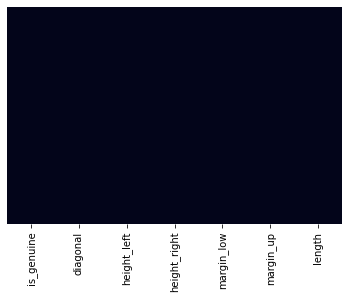

In [ ]:
sns.heatmap(notes.isnull(), yticklabels=False, cbar=False) # cmap="viridis"

In [ ]:
print('Détails des valeurs manquantes:\n' + str(notes.isna().sum()) + '\n')

Détails des valeurs manquantes:
is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64



Aucune valeur manquante ne se trouve dans nos données. On regarde ensuite s'il existe des valeurs dupliquées.

In [ ]:
print('Valeurs dupliquées: ' + str(notes.duplicated().sum()))

Valeurs dupliquées: 0


Aucune valeur dupliquée ne se trouve dans nos données.

#### analyse descriptive

Afin d'introduire notre analyse, effectuons une brève description des données

In [ ]:
notes.shape

(170, 7)

In [ ]:
notes.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [ ]:
notes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


Le dataset est composé de sept colonnes et de 170 lignes. Parmi les colonnes, on retrouve une colonne de type booléen (is_genuine) et 6 colonnes de numérique (float).

## Mission 0


### **analyse univarié**

#### **summary**

In [ ]:
notes.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [ ]:
print(f"SKEWNESS:\n{'-' * 23}\n{notes.skew()}\n")

SKEWNESS:
-----------------------
is_genuine     -0.361769
diagonal        0.196167
height_left     0.028648
height_right    0.168886
margin_low      0.584859
margin_up      -0.204313
length         -0.656478
dtype: float64



In [ ]:
print(f"KURTOSIS:\n{'-' * 23}\n{notes.kurtosis()}\n")

KURTOSIS:
-----------------------
is_genuine     -1.891517
diagonal        0.586844
height_left    -0.461713
height_right   -0.004884
margin_low     -0.743786
margin_up       0.549241
length         -0.533677
dtype: float64



Skewness is usually described as a measure of a dataset’s symmetry – or lack of symmetry. A perfectly symmetrical data set will have a skewness of 0.   The normal distribution has a skewness of 0.

> So, when is the skewness too much?  The rule of thumb seems to be:

- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
- If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed

For skewness, if the value is greater than + 1.0, the distribution is right skewed. In statistics, a positively skewed (or right-skewed) distribution is a type of distribution in which most values are clustered around the left tail of the distribution while the right tail of the distribution is longer. The positively skewed distribution is the direct opposite of the negatively skewed distribution.

If the value is less than -1.0, the distribution is left skewed.

---
**Central Tendency Measures in Positively Skewed Distributions**
> **Mean**  >  **Median**  >  **Mode**

---
The positive skewness of a distribution indicates that an investor may expect frequent small losses and a few large gains from the investment. The positively skewed distributions of investment returns are generally more desired by investors since there is some probability of gaining huge profits that can cover all the frequent small losses.

Most often, kurtosis is measured against the normal distribution.

- If the kurtosis is **close to 0**, then a normal distribution is often assumed.  These are called **mesokurtic** distributions.
- If the kurtosis is **less than zero**, then the distribution is light tails and is called a **platykurtic** distribution.
- If the kurtosis is **greater than zero**, then the distribution has heavier tails and is called a **leptokurtic** distribution.

For kurtosis, if the value is greater than + 1.0, the distribution is leptokurtik. If the value is less
than -1.0, the distribution is platykurtik.

#### **genuineness**

In [ ]:
sorted(notes.is_genuine.unique())

[False, True]

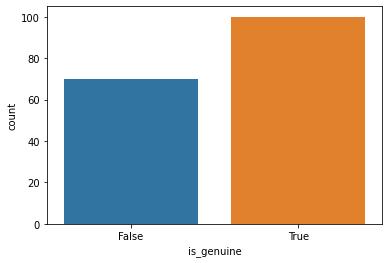

In [ ]:
sns.countplot(x="is_genuine", data=notes)

In [ ]:
print(f"Total values in column [is_genuine]: {len(notes.is_genuine)}\n")
print(f"Total [True] values: {notes[notes['is_genuine'] == True]['is_genuine'].count()}")
print(f"Total [False] values: {notes[notes['is_genuine'] == False]['is_genuine'].count()}")

Total values in column [is_genuine]: 170

Total [True] values: 100
Total [False] values: 70


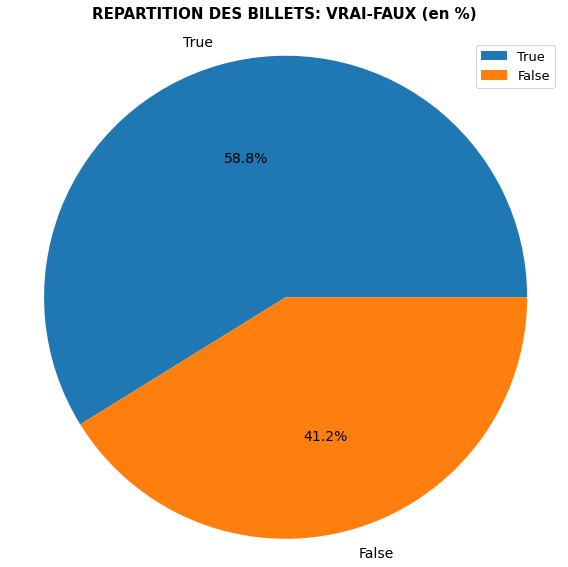

In [ ]:
# category distribution
plt.figure(figsize=(8,8))

labels= notes["is_genuine"].unique()
sizes= notes["is_genuine"].value_counts(normalize=True)
plt.pie(sizes, labels=labels, startangle=0, autopct="%1.1f%%", textprops={"fontsize": 14})

plt.title("REPARTITION DES BILLETS: VRAI-FAUX (en %)", fontsize=15, fontweight="bold", pad=20)
plt.axis("equal")
plt.legend(fontsize=13, loc=1)
plt.tight_layout()

plt.show()

In [ ]:
notes.groupby("is_genuine").mean()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.889857,104.230429,104.145571,5.281571,3.334571,111.660714
True,171.976100,103.951500,103.775900,4.143500,3.055500,113.207200


*Portrait-moyen du vrai billet :*

- Hauteur mesurée à gauche : 103.95 mm,
- Hauteur mesurée à droite : 103.77 mm,
- Marge entre le bord supérieur et le bord de l'image : 4.14 mm,
- Marge entre le bord inférieur et le bord de l'image : 3.05mm
- Longueur : 113.20 mm,
- Diagonale : 171.97 mm.

In [ ]:
print(f"SKEWNESS:\n{'-' * 23}\n{notes.groupby('is_genuine').describe().T.skew()}\n")
print(f"KURTOSIS:\n{'-' * 23}\n{notes.groupby('is_genuine').describe().T.kurtosis()}\n")

SKEWNESS:
-----------------------
is_genuine
False    0.120035
True    -0.070345
dtype: float64

KURTOSIS:
-----------------------
is_genuine
False   -1.225823
True    -1.335396
dtype: float64



In [ ]:
notes.groupby('is_genuine').describe().T

is_genuine               False        True
diagonal     count   70.000000  100.000000
             mean   171.889857  171.976100
             std      0.297426    0.307981
             min    171.380000  171.040000
             25%    171.682500  171.790000
             50%    171.875000  172.005000
             75%    172.047500  172.162500
             max    173.010000  172.750000
height_left  count   70.000000  100.000000
             mean   104.230429  103.951500
             std      0.213130    0.296251
             min    103.780000  103.230000
             25%    104.082500  103.740000
             50%    104.215000  103.915000
             75%    104.377500  104.145000
             max    104.720000  104.860000
height_right count   70.000000  100.000000
             mean   104.145571  103.775900
             std      0.253152    0.292406
             min    103.440000  103.140000
             25%    103.982500  103.557500
             50%    104.170000  103.760000
             75%    104.280000  103.972500
             max    104.860000  104.950000
margin_low   count   70.000000  100.000000
             mean     5.281571    4.143500
             std      0.540846    0.314509
             min      3.820000    3.540000
             25%      4.952500    3.900000
             50%      5.265000    4.080000
             75%      5.702500    4.382500
             max      6.280000    5.040000
margin_up    count   70.000000  100.000000
             mean     3.334571    3.055500
             std      0.185102    0.197726
             min      2.980000    2.270000
             25%      3.185000    2.937500
             50%      3.335000    3.070000
             75%      3.450000    3.192500
             max      3.680000    3.530000
length       count   70.000000  100.000000
             mean   111.660714  113.207200
             std      0.676931    0.380476
             min    109.970000  111.760000
             25%    111.270000  112.995000
             50%    111.765000  113.210000
             75%    111.985000  113.505000
             max    113.640000  113.980000

### **analyse bivarié**

In [ ]:
notes.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.139223,-0.461730,-0.551309,-0.800111,-0.582801,0.825743
diagonal,0.139223,1.000000,0.319584,0.220418,-0.181020,-0.027366,0.080295
height_left,-0.461730,0.319584,1.000000,0.734390,0.424530,0.324788,-0.421387
height_right,-0.551309,0.220418,0.734390,1.000000,0.509375,0.366918,-0.417021
margin_low,-0.800111,-0.181020,0.424530,0.509375,1.000000,0.171113,-0.637352
margin_up,-0.582801,-0.027366,0.324788,0.366918,0.171113,1.000000,-0.525284
length,0.825743,0.080295,-0.421387,-0.417021,-0.637352,-0.525284,1.000000


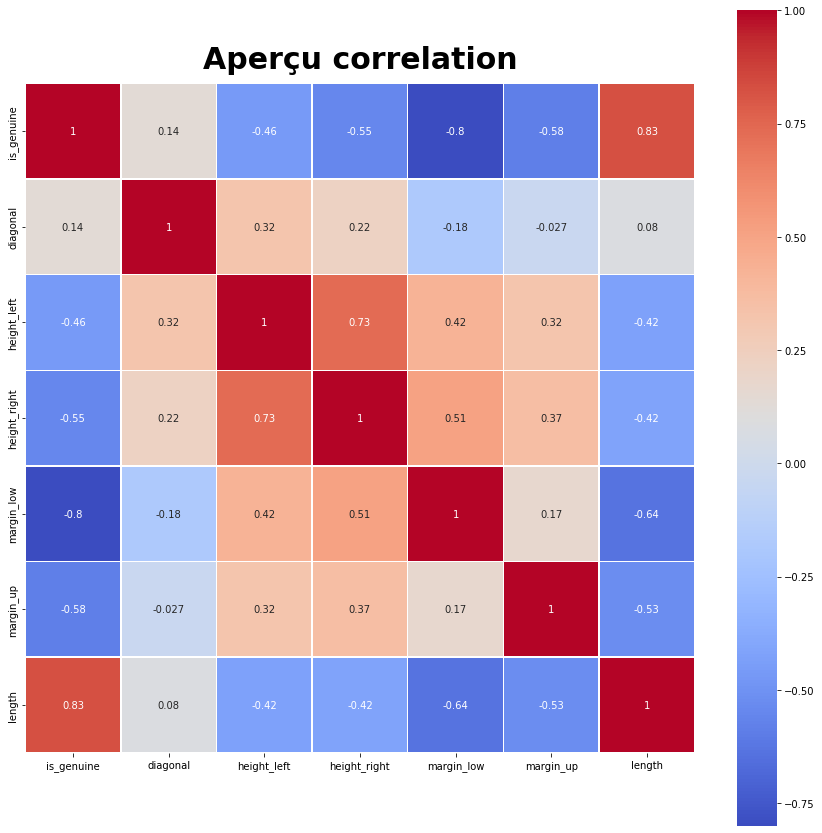

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(notes.corr(), square=True, annot=True, linewidths=.5, cmap='coolwarm')
# chart settings
plt.title("Aperçu correlation", fontsize=30, fontweight="bold", pad=15)
plt.show()

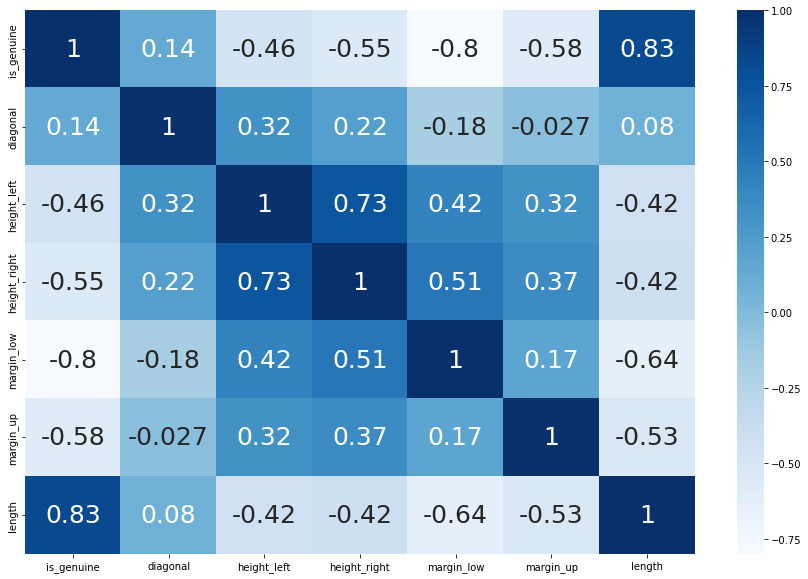

In [ ]:
# matrice en graphique
matrice = notes.corr()
plt.figure(figsize=(15,10))
sns.heatmap(matrice, annot=True, cmap='Blues', annot_kws={"size":25})

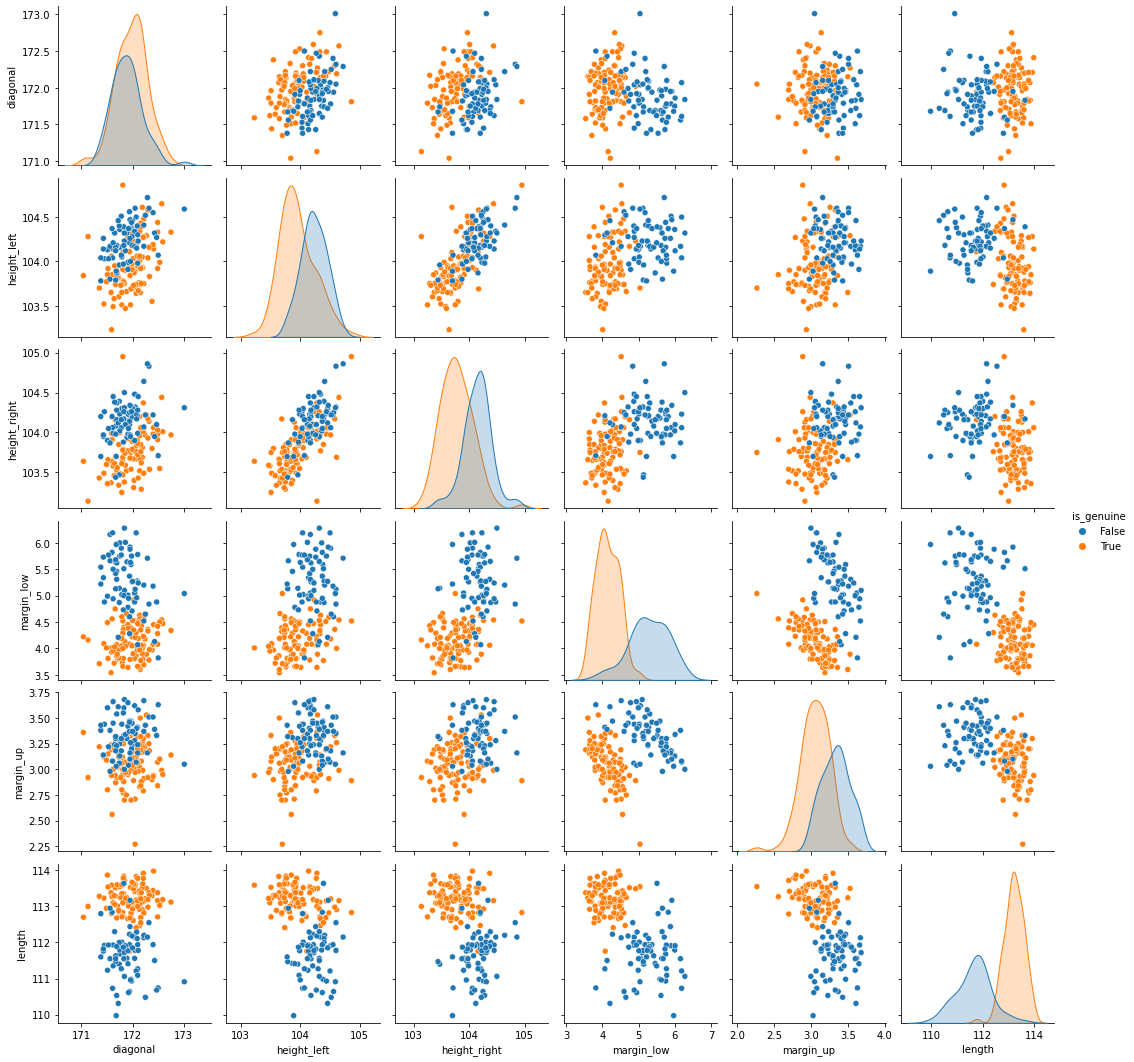

In [ ]:
sns.pairplot(notes, hue='is_genuine')
# pplot = sns.pairplot(notes, hue='is_genuine', corner=False)
# pplot = plt.tight_layout()
# pplot = plt.show()

marginlos et lenght proche de -1 = significatif

quand correle, l'autre varible est inutile cre les 2 montent (proche de 1)

(seulement pour qnttve)


lenght/margin low is genuine

biva marginlow lenght

uni distribution boite moistahce lenght mrin low (variable is genuine)




In [ ]:
# sns.relplot(data=notes, x="height_left", y="height_right", hue="is_genuine")
# sns.relplot(data=notes, x="margin_up", y="margin_low", hue="is_genuine")
# sns.relplot(data=notes, x="margin_low", y="margin_up", hue="is_genuine")
# sns.relplot(data=notes, x="diagonal", y="length", hue="is_genuine")
# sns.relplot(data=notes, x="length", y="diagonal", hue="is_genuine")

In [ ]:
# T = notes[notes["is_genuine"]==True]
# F = notes[notes["is_genuine"]==False]

# margin = sns.relplot(data=notes, x="margin_up", y="margin_low", col="is_genuine", color="gray") # col="is_genuine
# # TRUE
# (margin.map(plt.axhline, y=T.margin_low.mean(), color="orange"))
# (margin.map(plt.axvline, x=T.margin_up.mean(), color="orange"))
# # FALSE
# (margin.map(plt.axhline, y=F.margin_low.mean(), color="b"))
# (margin.map(plt.axvline, x=F.margin_up.mean(), color="b"))

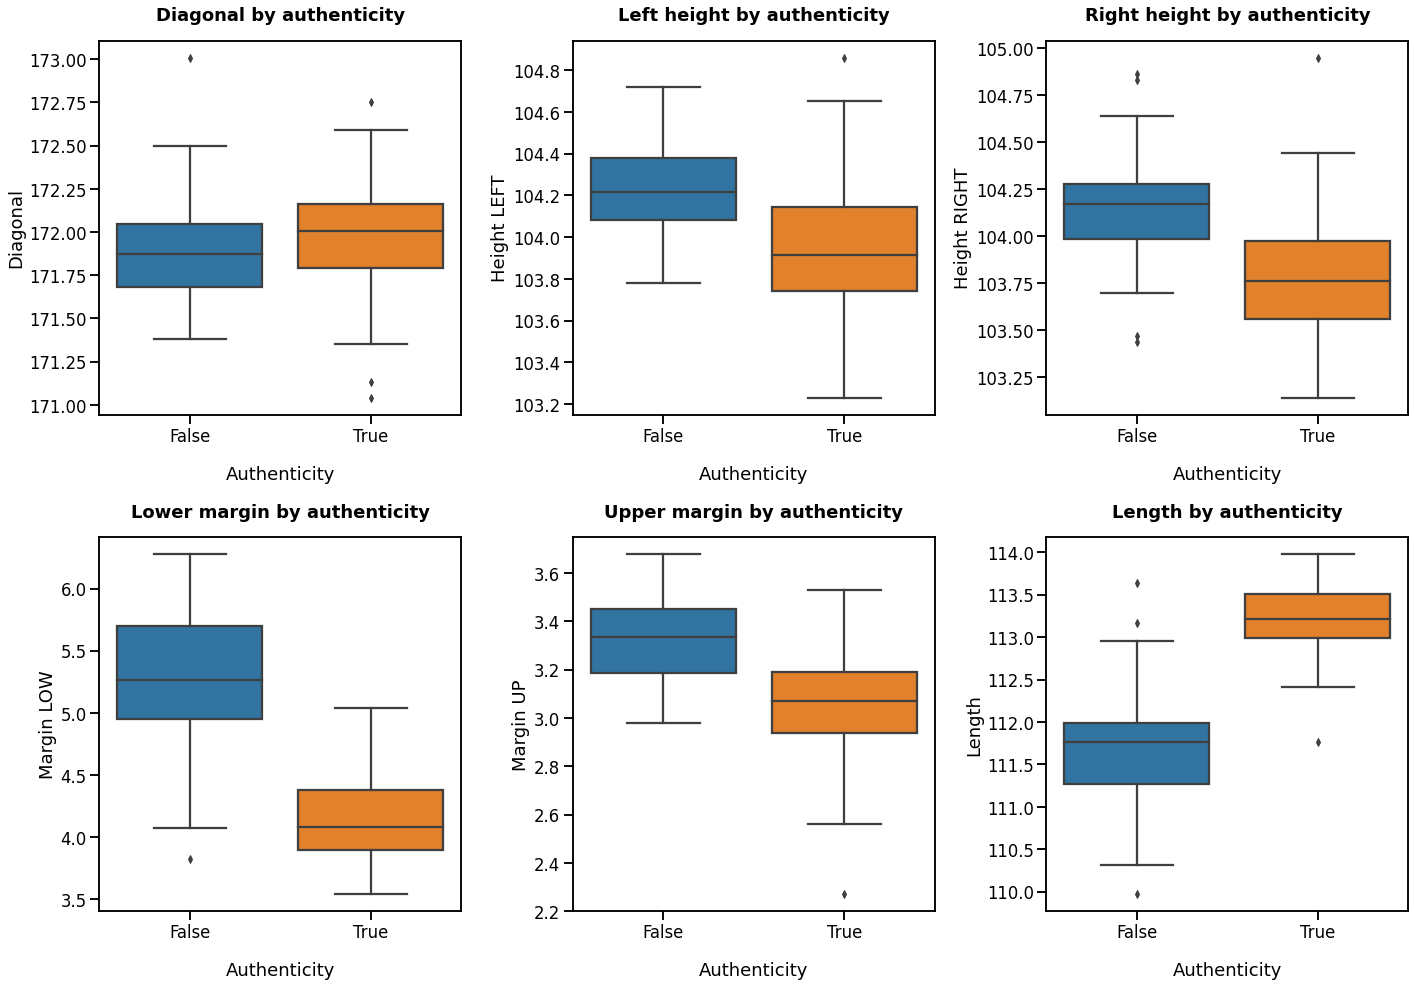

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
a = sns.boxplot(x='is_genuine', y="diagonal", data=notes)
a = plt.xlabel('Authenticity', labelpad=20)
a = plt.ylabel('Diagonal')
a = plt.title('Diagonal by authenticity', pad=20, fontweight='bold')

plt.subplot(3,3,2)
c = sns.boxplot(x='is_genuine', y="height_left", data=notes)
c = plt.xlabel('Authenticity', labelpad=20)
c = plt.ylabel('Height LEFT')
c = plt.title('Left height by authenticity', pad=20, fontweight='bold')

plt.subplot(3,3,3)
d = sns.boxplot(x='is_genuine', y="height_right", data=notes)
d = plt.xlabel('Authenticity', labelpad=20)
d = plt.ylabel('Height RIGHT')
d = plt.title('Right height by authenticity', pad=20, fontweight='bold')

plt.subplot(3,3,4)
e = sns.boxplot(x='is_genuine', y="margin_low", data=notes)
e = plt.xlabel('Authenticity', labelpad=20)
e = plt.ylabel('Margin LOW')
e = plt.title('Lower margin by authenticity', pad=20, fontweight='bold')

plt.subplot(3,3,5)
f = sns.boxplot(x='is_genuine', y="margin_up", data=notes)
f = plt.xlabel('Authenticity', labelpad=20)
f = plt.ylabel('Margin UP')
f = plt.title('Upper margin by authenticity', pad=20, fontweight='bold')

plt.subplot(3,3,6)
b = sns.boxplot(x='is_genuine', y="length", data=notes)
b = plt.xlabel('Authenticity', labelpad=20)
b = plt.ylabel('Length')
b = plt.title('Length by authenticity', pad=20, fontweight='bold')

plt.tight_layout()

In [ ]:
# plt.figure(figsize=(25,5))
# s = sns.countplot(x="length", data=notes, hue="is_genuine")
# s = plt.tight_layout()
# s = plt.show()

# sns.relplot(data=notes, x="diagonal", y="length", hue="is_genuine").set(title="Length vs Diagonal")
# sns.relplot(data=notes, x="height_left", y="length", hue="is_genuine").set(title="Length vs Left height")
# sns.relplot(data=notes, x="height_right", y="length", hue="is_genuine").set(title="Length vs Right height")
# sns.relplot(data=notes, x="margin_low", y="length", hue="is_genuine").set(title="Length vs Lower margin")
# sns.relplot(data=notes, x="margin_up", y="length", hue="is_genuine").set(title="Length vs Upper margin")

# len_low = sns.relplot(data=notes, x="margin_low", y="length", col="is_genuine")
# len_low.fig.subplots_adjust(top=.7)
# len_low.fig.suptitle('Differences between AUTHENTIC and FAKE bills')

### [**bonus**] distribution gaussienne

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


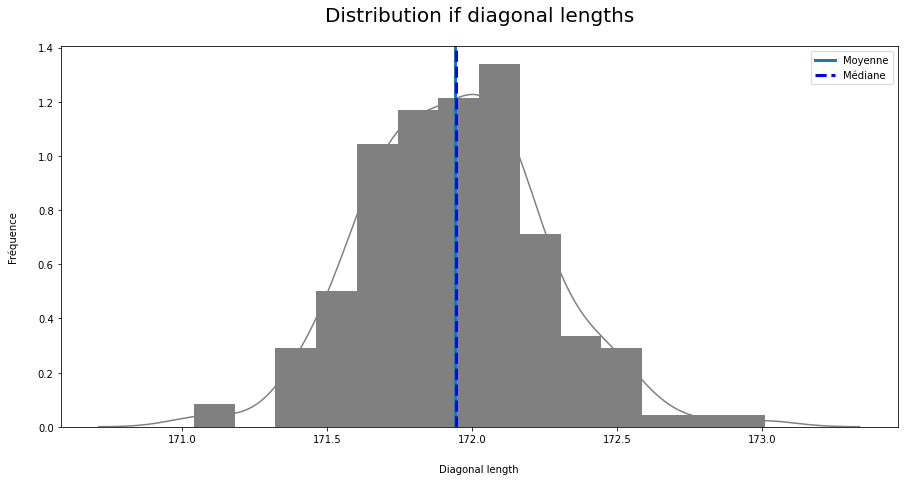

In [ ]:
norm_hist = notes["diagonal"]
# print("Disponibilité protéines par habitant:\n")

xbar = np.mean(norm_hist)
# print(f"Mean (esperance) = {round(xbar,2)}")

med = np.median(norm_hist)
# print(f"Median = {round(med,2)}")

sigma = np.std(norm_hist, ddof=1)
# print(f"Std (écart-type) = {round(sigma,2)}")

n_essence = len(notes)
sigmasq = np.var(norm_hist, ddof=1)
# print(f"Variance = {round(sigmasq,2)}")

show_norm = plt.figure(figsize=(15,7))
show_norm = sns.distplot(norm_hist,
                  kde=True,
                  color="gray",
                  hist_kws={"linewidth": 15, "alpha":1})
show_norm = plt.axvline(x=norm_hist.mean(), label="Moyenne", linestyle="-", linewidth=3)
show_norm = plt.axvline(x=norm_hist.median(), label="Médiane", linestyle="--", linewidth=3, color="blue")
show_norm = plt.xlabel("Diagonal length", labelpad=20)
show_norm = plt.ylabel("Fréquence", labelpad=20)
show_norm = plt.title("Distribution if diagonal lengths", fontsize=20, pad=25)
show_norm = plt.legend()


show_norm = plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


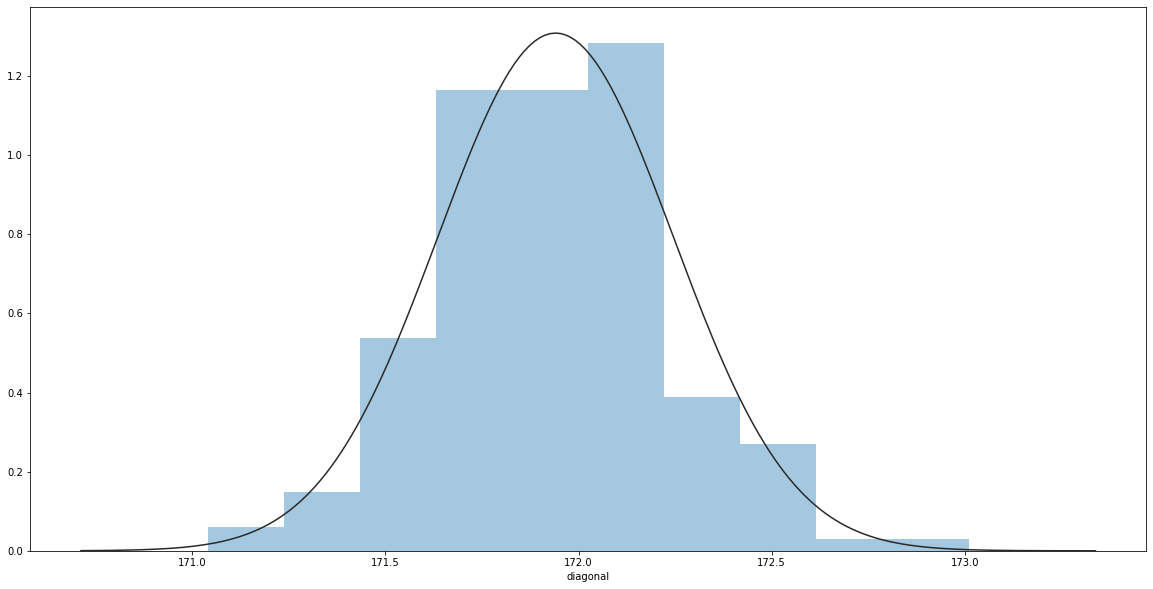

In [ ]:
sns.distplot(notes.diagonal, bins=10, fit=norm, kde=False)
plt.gcf().set_size_inches(20,10)

## Mission 1

### **normalisation**

In [ ]:
df = notes.copy()

# préparation des données pour l'ACP
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
x = df.loc[:, features].values
# centrage et réduction
x = StandardScaler().fit_transform(x) # normalizing the features
# nombre de lignes et colonnes
x.shape

(170, 6)

Let's check whether the normalized data has a mean of zero and a standard deviation of one.

In [ ]:
np.mean(x),np.std(x)

(1.0146132300339078e-14, 0.9999999999999999)

Let's convert the normalized features into a tabular format with the help of DataFrame.

In [ ]:
# feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
feat_cols = features

normalised_data = pd.DataFrame(x,columns=feat_cols)
normalised_data.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.428344,2.669454,3.096563,-0.131590,-1.189874,0.281633
1,-0.887559,-1.097697,-0.691254,-0.860126,-1.274740,0.780697
2,-0.362742,-1.030427,-0.509439,-0.303010,-1.232307,1.377405
3,-0.461145,-0.963156,-0.842767,-1.260106,-0.213913,1.149571
4,0.358883,-1.232238,-0.539742,0.611230,-3.820725,1.062777


### **visualisation**

In [ ]:
# Calcul des composantes principales
pca_df = PCA(n_components=2).fit(x)
principalComponents_pca = pca_df.transform(x)

#### 1. Analyse de l'éboulis des valeurs propres

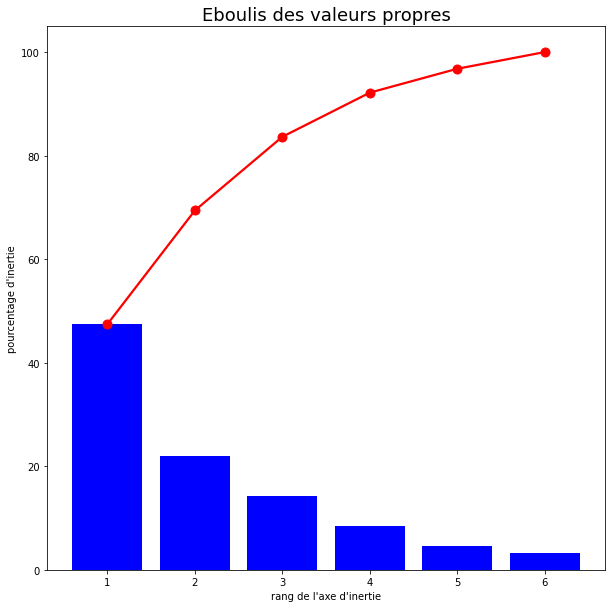

In [ ]:
# Eboulis des valeurs propres
display_scree_plot(PCA(n_components=6).fit(x))

As the number of PCs is equal to the number of original variables, We should keep only the PCs which explain the most variance (70-95%) to make the interpretation easier. More the PCs you include that explains most variation in the original data, better will be the PCA model. This is highly subjective and based on the user interpretation (Cangelosi et al., 2007).

#### >>> choix des composantes

Next, let's create a DataFrame that will have the principal component values for all 170 samples.

In [ ]:
principal_pca_df = pd.DataFrame(data = principalComponents_pca, columns = ['principal component 1', 'principal component 2'])
principal_pca_df.head()

,principal component 1,principal component 2
0,2.153639,1.599709
1,-2.110416,-0.526039
2,-1.973152,-0.048102
3,-2.059795,-0.089105
4,-2.403180,0.412170


#### >>> expained variance ratio

Once you have the principal components, you can find the explained_variance_ratio. It will provide you with the amount of information or variance each principal component holds after projecting the data to a lower dimensional subspace.

In [ ]:
print('Explained variation per principal component: {}'.format(pca_df.explained_variance_ratio_))
print(f"rounded: {pca_df.explained_variance_ratio_*100}")

Explained variation per principal component: [0.47447921 0.21957106]
rounded: [47.44792058 21.95710596]


In [ ]:
# quickier explained variance ratio test
df_transform = StandardScaler().fit_transform(x)
pca = PCA(n_components=2).fit(df_transform)
new_df = pca.transform(df_transform)
var_exp = pca.explained_variance_ratio_
var_exp

array([0.47447921, 0.21957106])

#### 2. Représentation des variables par le cercle des corrélations

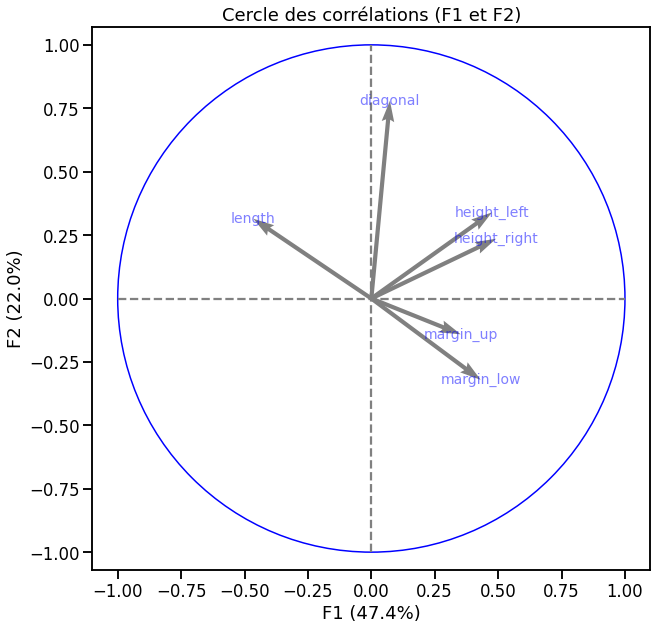

In [ ]:
pcs = pca_df.components_
display_circles(pcs, 2, pca_df, [(0,1)], labels = np.array(features))

La variable diagonal contribue fortement (et positivement) à l'axe 2

Les variables height_left et height_right contribuent le plus et positivement à l'axe 1.

Les variables margin_up et margin_low contribuent positivement à l'axe 1.

La variable length contribue négativement à l'axe 1.

From the above output, you can observe that the principal component 1 holds 60.4% of the information while the principal component 2 holds only 18.8% of the information. Also, the other point to note is that while projecting 5-dimensional data to a 2-dimensional data, 20.8% information was lost.

F1 : Longueur du billet VS hauteur / marge F2 : Longueur de la diagonale

Je n'ai conservé que cette projection car elle est de loin la plus pertinente.

On voit que l'axe de la première composante est celui qui sépare principalement les vrais billets des faux billets. De plus, F1 explique 47% de l'inertie.

Le second axe explique 22% de l'inertie et participe à la séparation des vrais billets et des faux billets.

#### 3. Représentation des individus par les plans factoriels 

Let's plot the visualization of the 177 samples along the principal component - 1 and principal component - 2 axis. It should give you good insight into how your samples are distributed among the two classes.

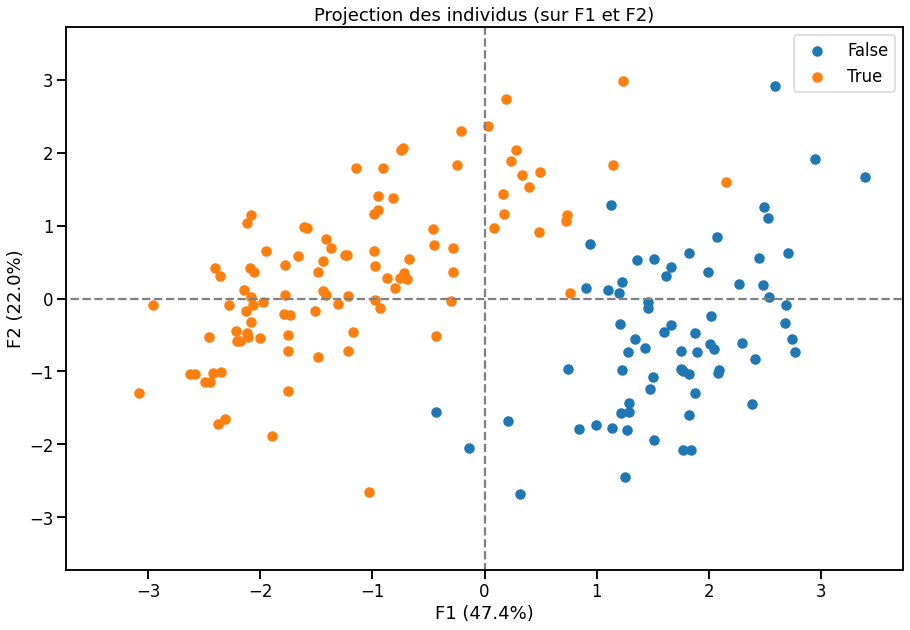

In [ ]:
n_comp = 2
X_scaled = x
dots = df['is_genuine']

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = dots) # , labels=df.pays

<Figure size 432x288 with 0 Axes>

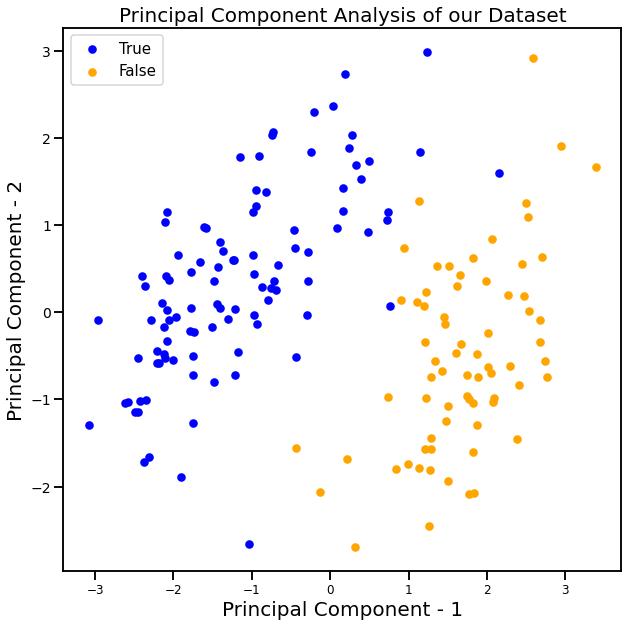

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of our Dataset",fontsize=20)
targets = [True, False]
colors = ['b','orange']
for target, color in zip(targets,colors):
    indicesToKeep = df['is_genuine'] == target
    plt.scatter(principal_pca_df.loc[indicesToKeep, 'principal component 1'], principal_pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

On voit qu'une diagonale sépare clairement les vrais et les faux billets. F1 permet dans de nombreux cas de déterminer s'il s'agit d'un vrai billet ou non. Pour les valeurs proches de zéro, alors c'est la valeur de F2 qui va permettre de discriminer.

## Mission 2

### **algorithme de classification**

In [ ]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [ ]:
df['id'] = df.index
df.index = df['id']
del df['id']
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,,
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [ ]:
# Nombre de clusters souhaités
n_clust = 2

# import de l'échantillon
df_prep = df[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

# préparation des données pour le clustering
X = df_prep.values

# réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)

# clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# index triés des groupes
clusters = np.argsort(km.labels_)

# affichage des observations et leurs groupes
df_km = pd.DataFrame(df.index[clusters], km.labels_[clusters])
df_km.head()

,id
0,0
0,74
0,73
0,72
0,71


In [ ]:
# ajout de la colonne cluster
df_km['kmeans_cluster'] = df_km.index
df_km.reset_index(drop=True, inplace=True)
df_km.head()

,id,kmeans_cluster
0,0,0
1,74,0
2,73,0
3,72,0
4,71,0


In [ ]:
df_km["kmeans_cluster"].unique()

array([0, 1])

In [ ]:
# renommer les groupes
df_km["kmeans_cluster"].replace({0: 1, 1: 2}, inplace=True)
df_km.head()

,id,kmeans_cluster
0,0,1
1,74,1
2,73,1
3,72,1
4,71,1


In [ ]:
df_km["kmeans_cluster"].unique()

array([1, 2])

In [ ]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
id,,,,,,,
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [ ]:
df["id"] = df.index
df.reset_index(drop=True, inplace=True)
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,True,171.81,104.86,104.95,4.52,2.89,112.83,0
1,True,171.67,103.74,103.70,4.01,2.87,113.29,1
2,True,171.83,103.76,103.76,4.40,2.88,113.84,2
3,True,171.80,103.78,103.65,3.73,3.12,113.63,3
4,True,172.05,103.70,103.75,5.04,2.27,113.55,4


In [ ]:
# jointure dataframe initiale avec les clusters
df_kmeans = pd.merge(df_km, df, on = 'id')
df_kmeans.head()

,id,kmeans_cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,1,True,171.81,104.86,104.95,4.52,2.89,112.83
1,74,1,True,172.10,103.94,103.75,3.66,3.20,113.78
2,73,1,True,171.52,103.92,103.66,3.81,3.15,113.54
3,72,1,True,171.97,103.69,104.17,4.32,3.00,112.82
4,71,1,True,172.17,103.93,103.62,4.06,3.08,113.10


In [ ]:
df_kmeans.groupby(["kmeans_cluster", "is_genuine"]).count()

id  diagonal  ...  margin_up  length
kmeans_cluster is_genuine                ...                   
1              False        2         2  ...          2       2
               True        99        99  ...         99      99
2              False       68        68  ...         68      68
               True         1         1  ...          1       1

[4 rows x 7 columns]

### [**bonus**] difference avant et après clustering

In [ ]:
# false = df[df["is_genuine"] == False]
# true = df[df["is_genuine"] == True]

# false_cluster = df_kmeans[df_kmeans["kmeans_cluster"] == 2]
# true_cluster = df_kmeans[df_kmeans["kmeans_cluster"] == 1]

# print("CLUSTER 1: considered as FAKE")
# print(f"-" * 50)
# print(f"Nb of FAKE bills in INITIAL data: {len(false)}")
# print(f"Nb of FAKE bills in CLUSTERED data: {len(false_cluster)}")
# print("\n")
# print("CLUSTER 2: considered as REAL")
# print(f"-" * 50)
# print(f"Nb of AUTHENTIC bills in INITIAL data: {len(true)}")
# print(f"Nb of AUTHENTIC bills in CLUSTERED data: {len(true_cluster)}")
# print("\n")
# print(f"-" * 100)

# not_true_anymore = set(true[true.id.isin(true_cluster.id)==False]["id"].unique())
# print(f'These {len(not_true_anymore)} bill(s) below are not listed in the TRUE cluster_2, means they are not considered AUTHENTIC bills anymore')
# print(not_true_anymore)
# print("\n")
# not_false_anymore = set(false[false.id.isin(false_cluster.id)==False]["id"].unique())
# print(f'These {len(not_false_anymore)} bill(s) below are not listed in the FALSE cluster_1: False, means they are not considered FAKE bills anymore')
# print(not_false_anymore)

In [ ]:
# df_kmeans['cluster_equivalence'] = np.where(df_kmeans['kmeans_cluster'] == 1, True, False)
# df_kmeans.head()

In [ ]:
# print(df_kmeans[df_kmeans["id"]==69][["id", "is_genuine", "kmeans_cluster", "cluster_equivalence"]])
# print(f"-" * 56)
# print(df_kmeans[df_kmeans["id"]==102][["id", "is_genuine", "kmeans_cluster", "cluster_equivalence"]])
# print(f"-" * 56)
# print(df_kmeans[df_kmeans["id"]==118][["id", "is_genuine", "kmeans_cluster", "cluster_equivalence"]])

In [ ]:
# true_cluster.describe()

In [ ]:
# false_cluster.describe()

### **visualisation de la partition obtenue dans le premier plan factoriel de l'ACP**

In [ ]:
# calcul des controïdes
cluster_average = df_kmeans.groupby('kmeans_cluster').mean()
cluster_average.head()

,id,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
kmeans_cluster,,,,,,,,
1,50.50495,0.980198,171.974653,103.956832,103.779208,4.159010,3.059406,113.216139
2,134.26087,0.014493,171.890725,104.226667,104.146087,5.275362,3.332899,111.625217


In [ ]:
# kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=30, random_state=0)
# pred_y = kmeans.fit_predict(X)
# plt.scatter(X[:,0], X[:,1])
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
# plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


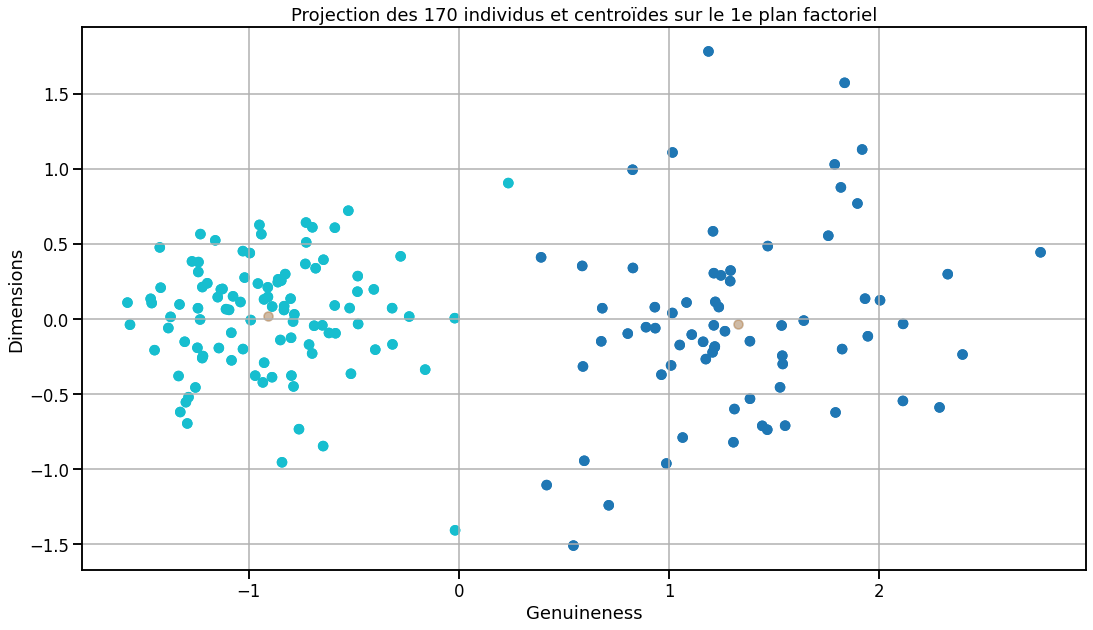

In [ ]:
# Nombre de clusters souhaités
n_clust = 2

#import de l'échantillon
data = notes[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

# préparation des données pour le clustering
X = notes.values

# réduire n'est ici pas nécessaire car les variables sont exprimées dans la même unité
# X_scaled = preprocessing.StandardScaler().fit_transform(X)

# clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# récupération des clusters attribués à chaque individu
clusters = km.labels_

# affichage du clustering par projection des individus sur le premier plan factoriel
plt.figure(figsize=(18,10))
pca = decomposition.PCA(n_components=6).fit(X)
X_projected = pca.transform(X)

# nuage de points TRUE and FALSE
label = {'Vrai', 'Faux'}
for color in label:
    plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'tab10', alpha=2)

# nuage de points CENTROÏDES
centroids = km.cluster_centers_ # nombre de clusters
centroids_projected = pca.transform(centroids) # projections des points selon les variables
label = {'Vrai', 'Faux'}
for color in label:
    plt.scatter(centroids_projected[:,0] ,centroids_projected[:,1], cmap='magma', alpha=0.3)

# titre
plt.title("Projection des {} individus et centroïdes sur le 1e plan factoriel".format(X_projected.shape[0]))
# titre des axes
plt.xlabel('Genuineness', fontsize=18)
plt.ylabel('Dimensions', fontsize=18)
# affichage
plt.grid()
plt.show(block=False)

Les points qui sont supérieures ou égales à 0.5, le billet est considéré comme vrai. Dans le cas contraire, il est considéré comme faux.


### [**bonus**] analyse descriptive du kmeans

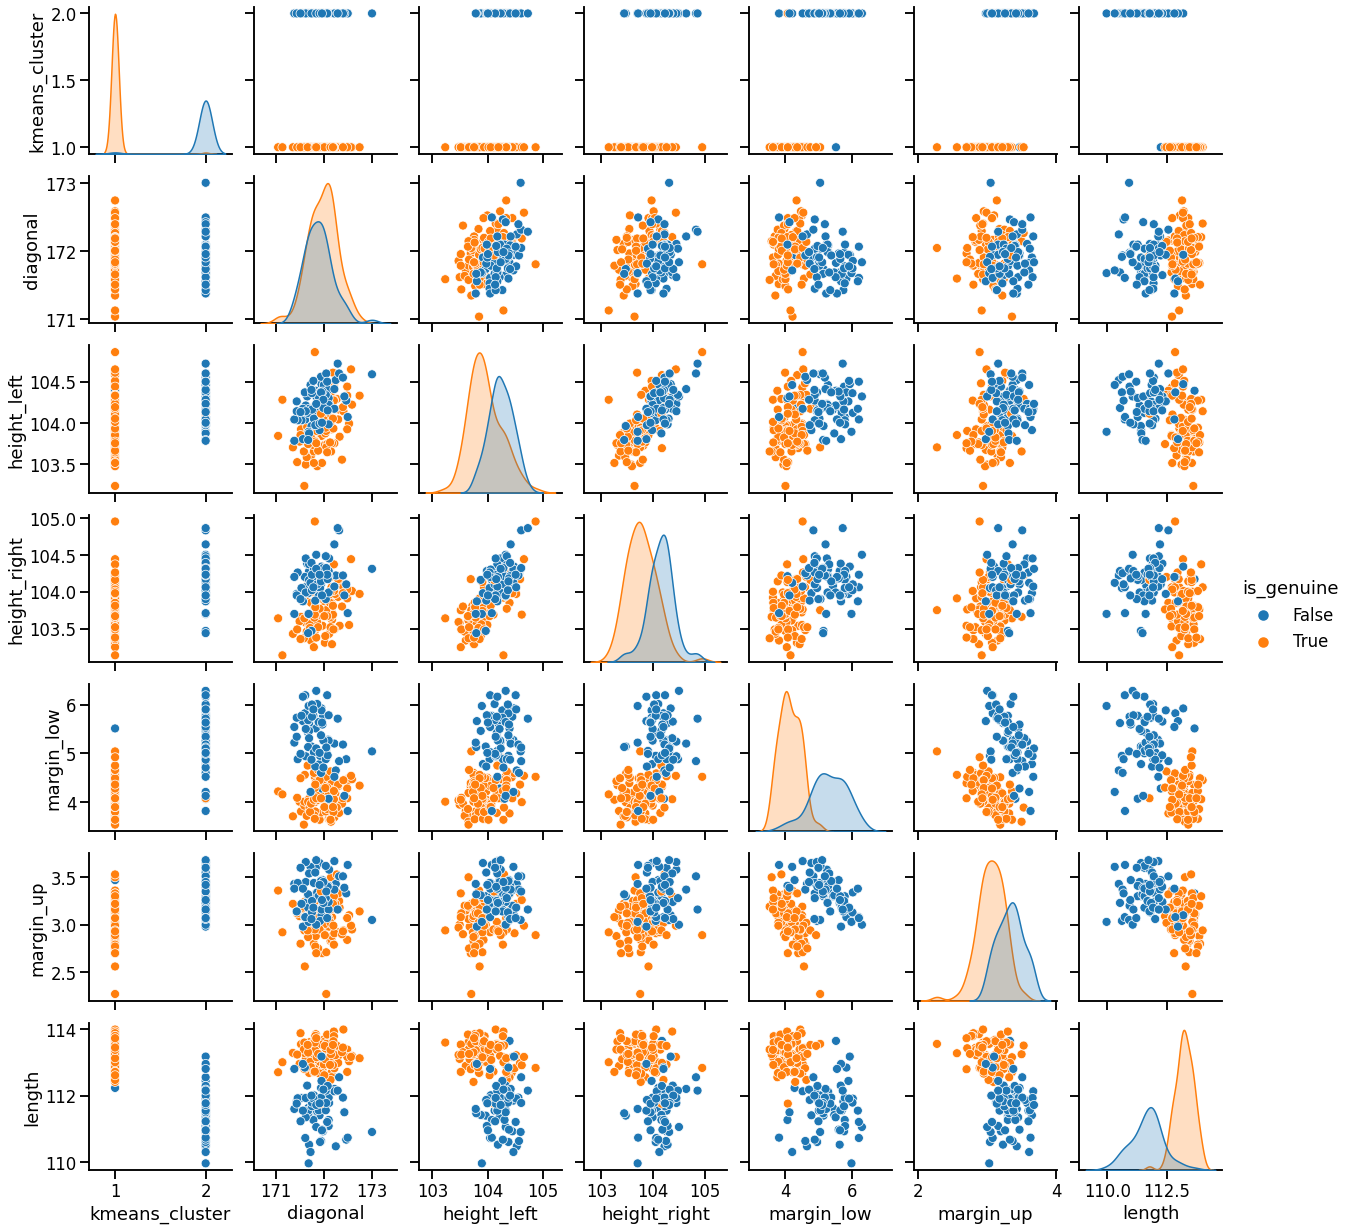

In [ ]:
kmeans_pairplot = df_kmeans[['is_genuine', 'kmeans_cluster', 'diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']]
sns.pairplot(kmeans_pairplot, hue='is_genuine')
# pplot = sns.pairplot(notes, hue='is_genuine', corner=False)
# pplot = plt.tight_layout()
# pplot = plt.show()

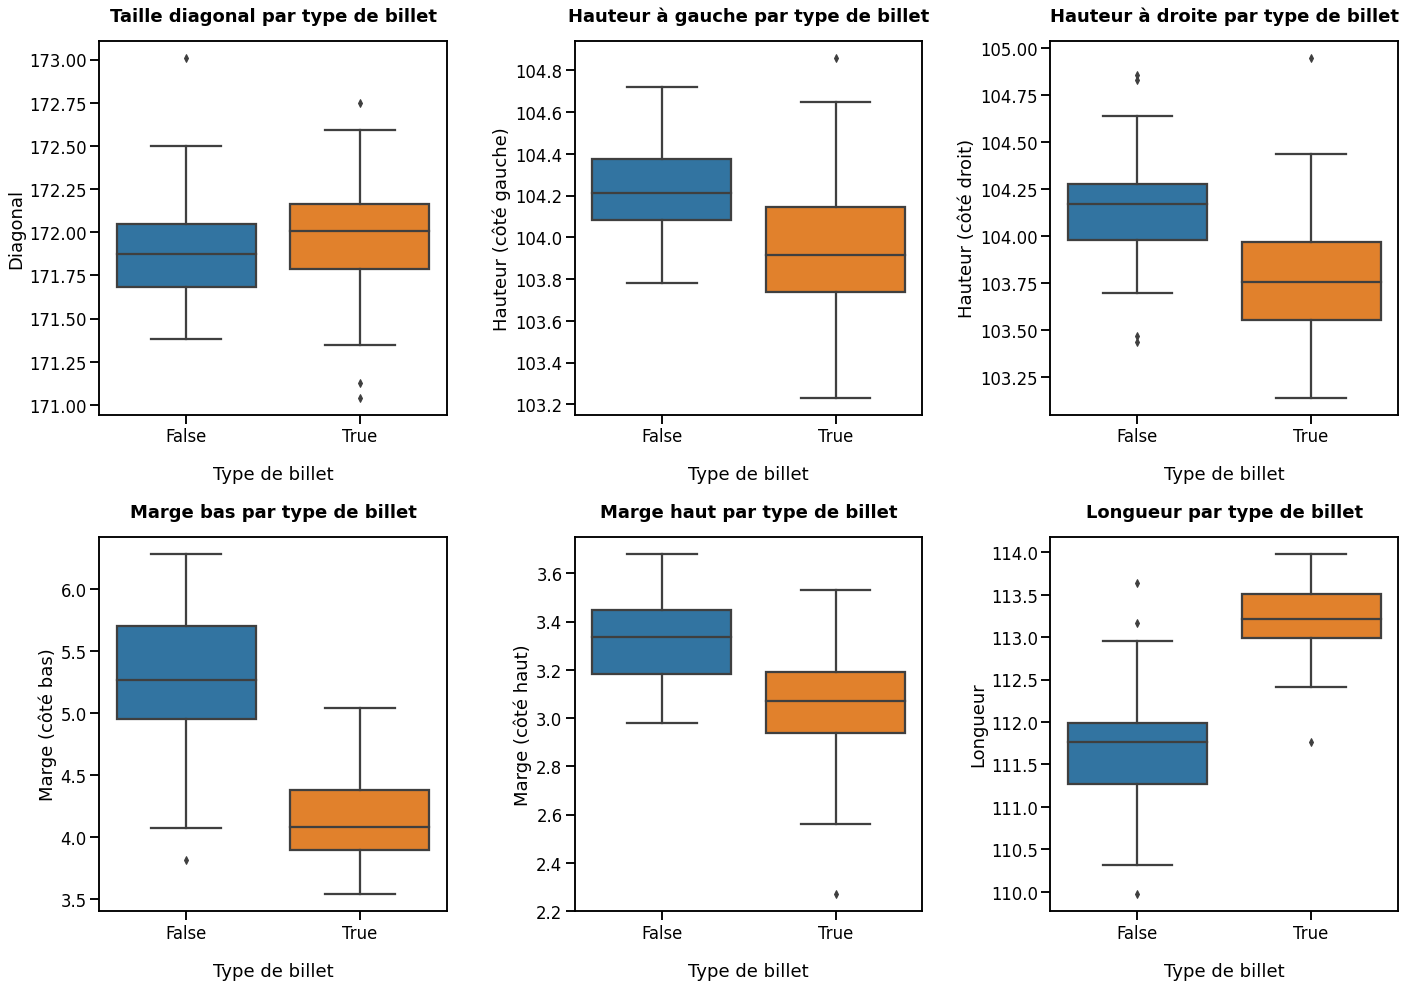

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(3,3,1)
a = sns.boxplot(x='is_genuine', y="diagonal", data=df_kmeans)
a = plt.xlabel('Type de billet', labelpad=20)
a = plt.ylabel('Diagonal')
a = plt.title('Taille diagonal par type de billet', pad=20, fontweight='bold')

plt.subplot(3,3,2)
c = sns.boxplot(x='is_genuine', y="height_left", data=df_kmeans)
c = plt.xlabel('Type de billet', labelpad=20)
c = plt.ylabel('Hauteur (côté gauche)')
c = plt.title('Hauteur à gauche par type de billet', pad=20, fontweight='bold')

plt.subplot(3,3,3)
d = sns.boxplot(x='is_genuine', y="height_right", data=df_kmeans)
d = plt.xlabel('Type de billet', labelpad=20)
d = plt.ylabel('Hauteur (côté droit)')
d = plt.title('Hauteur à droite par type de billet', pad=20, fontweight='bold')

plt.subplot(3,3,4)
e = sns.boxplot(x='is_genuine', y="margin_low", data=df_kmeans)
e = plt.xlabel('Type de billet', labelpad=20)
e = plt.ylabel('Marge (côté bas)')
e = plt.title('Marge bas par type de billet', pad=20, fontweight='bold')

plt.subplot(3,3,5)
f = sns.boxplot(x='is_genuine', y="margin_up", data=df_kmeans)
f = plt.xlabel('Type de billet', labelpad=20)
f = plt.ylabel('Marge (côté haut)')
f = plt.title('Marge haut par type de billet', pad=20, fontweight='bold')

plt.subplot(3,3,6)
b = sns.boxplot(x='is_genuine', y="length", data=df_kmeans)
b = plt.xlabel('Type de billet', labelpad=20)
b = plt.ylabel('Longueur')
b = plt.title('Longueur par type de billet', pad=20, fontweight='bold')

plt.tight_layout()

## Mission 3

### 1. Regression logistique (train and test)

In [ ]:
# determining variables
# x = notes.drop(["is_genuine"], axis=1)
x = notes[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = notes["is_genuine"]


# splitting data set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)


# initial information
print("-" * 75)
print(f"1. Initial information")
print("-" * 75)
print(f"Total values in the data set: {len(notes)}")
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("\n")


# checking data from train and test set
print("-" * 75)
print(f"2. Train and Test data set")
print("-" * 75)
print(X_test)
print(f"TEST DATA SET: {X_test.shape}")
# print(X_train)
print("\n")


# perform logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)


# perform prediction using the model (test data set)
print("-" * 75)
print(f"3. Prediction performance on X_test set")
print("-" * 75)
y_pred = logreg.predict(X_test)
print(f"Nb of values in X_test: {len(y_pred)}")
print("\n")
print(y_pred)
print("\n")


# display Confusion Matrix
# we want false positive and negative to be as low as possible
print("-" * 75)
print(f"4. Confusion matrix")
print("-" * 75)
print(confusion_matrix(y_test, y_pred))
print("\n")
print(f"Nb of Actual True: {np.sum(y_test)}")
print(f"Nb of Predicted True: {np.sum(y_pred)}")
print("Out of 34 tested, 2 were predicted wrongly.")
print("\n")


# confusion matrix table
print("-" * 75)
print(f"5. Displaying confusion matrix table with labels")
print("-" * 75)
def plot_confusion_matrix(y_real, y_predicted):
  labels = unique_labels(y_real)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_real, y_predicted), columns=columns, index=index)
  return table
print(plot_confusion_matrix(y_test, y_pred))
print("\n")


# evaluate how the model has been performing
print("-" * 75)
print(f"6. Evaluate how the model has been performing")
print("-" * 75)
print(classification_report(y_test, y_pred))
# print("\n")

# scoring
true_positive = 22
true_negative = 10

false_positive = 2
false_negative = 0

actual_positive = 22
predictetd_positive = 24

actual_negative = 12
predicted_negative = 10

print("-" * 75)
print(f"7. Understanding the score ratings")
print("-" * 75)
print(f"À quelle fréquence le classificateur (prédiction) est-il correct, dans l'ensemble ?\nACCURACY = {(true_positive + true_negative) /len(y_pred)}")
print("\n")
print(f"À quelle fréquence le classificateur (prédiction) est-il erroné, dans l'ensemble ?\nMAUVAISE CLASSIFICATION ou TAUX D'ERREUR = {1- ((true_positive + true_negative) /len(y_pred))}")
print("\n")
print(f"Quand c'est vraiment oui, à quelle fréquence prédit-il oui (également appelé 'Sensibilité' ou 'Rappel') ?\nTAUX DE VRAIS POSITIFS = {true_positive /actual_positive}")
print("\n")
print(f"Quand c'est en fait non, à quelle fréquence prédit-il oui ?\nTAUX DE FAUX POSITIFS = {false_positive /actual_negative}")
print("\n")
print(f"Quand c'est non, à quelle fréquence prédit-il non (également appelé 'Spécificité') ?\nTAUX DE VRAIS NEGATIF = {1-(false_positive /actual_negative)}")
print("\n")
print(f"Lorsqu'il prédit oui, à quelle fréquence est-il correct ?\nPRECISION = {true_positive/predictetd_positive}")
print("\n")

---------------------------------------------------------------------------
1. Initial information
---------------------------------------------------------------------------
Total values in the data set: 170
Train set: (136, 6)
Test set: (34, 6)


---------------------------------------------------------------------------
2. Train and Test data set
---------------------------------------------------------------------------
     diagonal  height_left  height_right  margin_low  margin_up  length
48     171.73       103.82        103.85        3.97       3.12  112.85
91     172.30       104.04        103.93        4.33       2.92  113.19
19     171.75       104.16        104.00        4.19       3.03  113.55
35     171.66       104.17        104.16        4.75       2.94  113.52
164    171.43       104.26        103.97        5.73       3.14  111.82
88     171.91       104.28        103.92        3.64       3.36  113.15
106    172.22       104.17        104.07        4.52       3.67  112

### 2. Automation program (authenticity validation)

Création d'un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet.

---
**Hypothésis Testing**
> Pour chaque billet, l'algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai (if p ≥ 0 = H0 accepted). Dans le cas contraire, il sera considéré comme faux (if p ≤ 0 = H0 rejected).

****utilisation du programme lors de la soutenance***

In [ ]:
sample_set = pd.read_csv('/content/drive/MyDrive/OC/P6/example.csv')
sample_set.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [ ]:
def authenticator(dataset):
  # prepare
  data = dataset[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
  print(f"Values in data: {len(data)}")
  # perform
  proba = logreg.predict_proba(data)
  print(f"Values predicted: {len(data)}")
  print("\n")
  # characterizing
  dataset["probability"] = proba[:,1]
  dataset["authenticity"] = np.where(dataset["probability"] >= 0.5, True, False)
  return dataset.head()

In [ ]:
authenticator(sample_set)

Values in data: 5
Values predicted: 5




,diagonal,height_left,height_right,margin_low,margin_up,length,id,probability,authenticity
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.050814,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.014250,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.037217,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.883493,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.996417,True


# [passing]

**Soutenance**

> Lors de la soutenance, l'examinateur vous procurera un fichier CSV contenant ***5 caractéristiques de billets***. Votre programme devra déterminer si chacun de ces billets est vrai ou faux, en affichant la probabilité associée. Ce fichier sera de la même forme que celui-ci : [example.csv](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/example.csv).

Dans ce fichier d'exemple, chaque billet possède un identifiant (dans la colonne **"id"**). Vérifiez que votre programme affiche bien cet identifiant pour chaque prédiction effectuée.

Assurez-vous que votre programme puisse bien lire ce fichier et effectuer la prédiction pour chacun des billets !

**Compétence à maîtriser**

- Réaliser une ACP
- Utiliser un algorithme de clustering de type Kmeans
- Modéliser grâce à la régression logistique
- Interpréter une ACP

#### **{sources}**

1. https://www.youtube.com/watch?v=VCJdg7YBbAQ&list=TLPQMjMwMjIwMjKophyIcF93tQ&index=2
2. https://www.youtube.com/watch?v=Cx8Xie5042M&list=TLPQMjMwMjIwMjKophyIcF93tQ&index=1
3. https://www.youtube.com/watch?v=fJoR3QsfXa0
4. https://seaborn.pydata.org/generated/seaborn.relplot.html
5. https://seaborn.pydata.org/tutorial/relational.html
6. https://s3.amazonaws.com/assets.datacamp.com/production/course_15192/slides/chapter2.pdf
7. https://www.datarmatics.com/data-science/how-to-perform-logistic-regression-in-pythonstep-by-step/
8. https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/
9. https://www.youtube.com/watch?v=zM4VZR0px8E&list=TLPQMDEwMzIwMjKFEg6U5kS6OQ&index=3
10. https://deepnote.com/@magdantho/p06fauxbillets-1T39piBIRb2aP0nhsHSOWQ
11. https://www.datainterviewpro.com/masterclass
12. https://www.youtube.com/channel/UCh9nVJoWXmFb7sLApWGcLPQ
13. https://www.youtube.com/watch?v=yIYKR4sgzI8&list=TLPQMDEwMzIwMjKFEg6U5kS6OQ&index=10
14. https://colab.research.google.com/drive/1Y5SpeE5CeLbxxIlKyXzXIKSRC3zKkXdA#scrollTo=UYbBgQxiJNlT
15. https://www.stat4decision.com/fr/faire-une-regression-logistique-avec-python/